In [279]:
# imports for this notebook
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan
from theano import tensor as tt
import pymc3
import scipy.stats as stats

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

Conditioned on the mode sequence, one may partition the observations into K different linear regression problems, where $K = \vert \{ z_1, \dots, z_T \} \vert$. So for each model $k$, we form a matrix $Y^{(k)}$, with $N_k$ columns consisting of the observations $y_t$ with $z_t = k$. Then, 
$$
Y^{(k)} = A^{(k)}\bar{Y}^{(k)} + E^{(k)}
$$
where $A^{(k)} = [A^{(k)}_1 \dots A^{(k)}_r$, $\bar{Y}^{(k)}$ is a matrix of lagged  observations and E is the associated noise vectors.

In [280]:
A = np.array([[1,2],[3,4]])
B = np.array([[1,0,4],[0,4,0],[1,1,1]])
np.kron(A,B)

array([[ 1,  0,  4,  2,  0,  8],
       [ 0,  4,  0,  0,  8,  0],
       [ 1,  1,  1,  2,  2,  2],
       [ 3,  0, 12,  4,  0, 16],
       [ 0, 12,  0,  0, 16,  0],
       [ 3,  3,  3,  4,  4,  4]])

# Use Gharamani-Hinton as first test

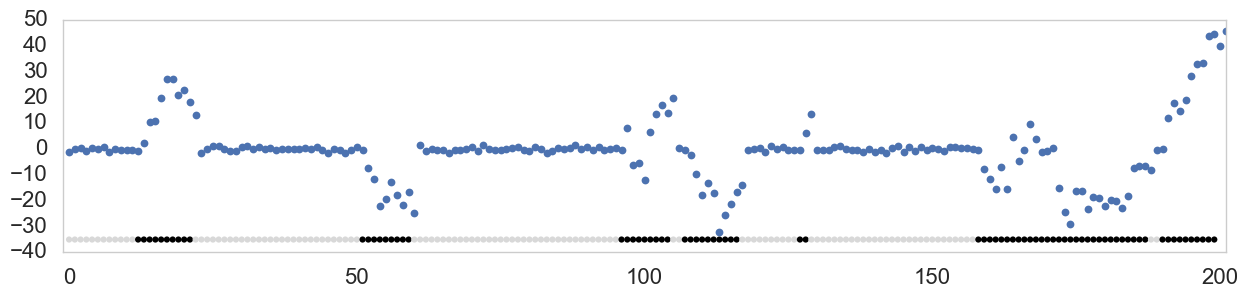

In [331]:
x1 = lambda x: 0.99*x + np.random.normal(0,np.sqrt(50))
x2 = lambda x: 0.01*x + np.random.normal(0,np.sqrt(0.5))
X = [x1, x2]

def generate_chain():
    ys = [np.random.normal(0,1)]
    
    chains = []
    chain = np.random.choice([0,1], p=[0.5,0.5])
    chains.append(chain)
    
    ys.append(X[chain](ys[-1]))

    for i in range(200):
        if np.random.uniform(0,1) < 0.05:
            if chain == 0:
                chain = 1
            else:
                chain = 0
        chains.append(chain)
        
        ys.append(X[chain](ys[-1]))
    return (np.array(chains), np.array(ys))

chains, ys = generate_chain()

fig, ax = plt.subplots(figsize=(15,3))
temp = np.arange(0,200,1)

c=['black','#d8d8d8']

plt.scatter(temp, -35*np.ones_like(temp), c=[c[i] for i in chains], lw=0)
plt.plot(ys, lw=0, marker='.')
plt.xlim([-1,201])
plt.grid(False)

# Successively test each of the steps for the HDP-AR model

In [332]:
import hdp_scripts
import imp
import time
imp.reload(hdp_scripts)

<module 'hdp_scripts' from '/Users/nickhoernle/Harvard/semester_2/bayesian_MIT/project/notebooks/hdp_scripts.py'>

In [333]:
params = {}

# define L=15 components:
L = 2
D = 1 # dimensionality of the data
params['pi'] = np.random.dirichlet(alpha=np.ones(L), size=L)
# params['pi'] = np.array([[0.95,0.05],[0.05,0.95]])
# params['theta'] = [{'A': np.random.normal(0,1), 'sigma': 10} for i in range(L)]
params['theta'] = [{'A': 0.01, 'sigma': np.sqrt(0.5)}, {'A': 0.99, 'sigma': np.sqrt(50)}]
params['L'] = L
params['Y'] = ys
params['T'] = len(ys)
params['alpha'] = 10
params['beta'] = np.random.dirichlet(np.ones(params['L']))
params['kappa'] = 100
params['gamma'] = 10
params['priors'] = {
    'M': np.zeros(shape=(D,D)),
    'K': np.linalg.pinv(10*np.eye(D))
}

In [334]:
# params['pi'] = pi_theta['pi']

In [335]:
params['pi']

array([[0.39547409, 0.60452591],
       [0.92359246, 0.07640754]])

Backward messages:

In [336]:
back_messages = hdp_scripts.backward_algorithm_slds(ys, params)
back_messages

array([[-1.08521973e+03, -1.08728809e+03],
       [-1.07977103e+03, -1.08183939e+03],
       [-1.05763375e+03, -1.05970212e+03],
       [-1.03239512e+03, -1.03446348e+03],
       [-1.00808568e+03, -1.01015404e+03],
       [-9.91045302e+02, -9.93113665e+02],
       [-9.75038249e+02, -9.77106613e+02],
       [-9.61566525e+02, -9.63634889e+02],
       [-9.52920904e+02, -9.54989267e+02],
       [-9.44957927e+02, -9.47026290e+02],
       [-9.36238501e+02, -9.38306864e+02],
       [-9.31932140e+02, -9.31365192e+02],
       [-9.30731559e+02, -9.29903359e+02],
       [-9.29151918e+02, -9.31220281e+02],
       [-9.23148054e+02, -9.25216417e+02],
       [-9.16935399e+02, -9.19003762e+02],
       [-9.08548785e+02, -9.10617148e+02],
       [-8.99878904e+02, -9.01947268e+02],
       [-8.79983350e+02, -8.82051713e+02],
       [-8.49810053e+02, -8.51878417e+02],
       [-8.22305217e+02, -8.24373580e+02],
       [-8.00734847e+02, -8.02803211e+02],
       [-7.75122932e+02, -7.77191295e+02],
       [-7.

Forward messages:

In [337]:
fwd_pass = hdp_scripts.state_assignments_slds(ys, back_messages, params)
fwd_pass['z']

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1], dtype=int16)

In [338]:
Y_bar = ys
S_ybarybar, S_yybar, S_yy = hdp_scripts.slds_sufficient_statistics(ys, Y_bar, fwd_pass, params)

In [339]:
Y_bar = np.zeros_like(ys)
Y_bar[1] = ys[1]
Y_bar[1:] = ys[0:-1]

In [340]:
z, Yk, n = fwd_pass['z'], fwd_pass['Yk'], fwd_pass['n']
n

array([[94, 20],
       [19, 69]], dtype=int16)

In [341]:
step3_update = hdp_scripts.step_3(fwd_pass, params)
mbar = step3_update['mbar']
beta = hdp_scripts.update_beta(mbar, params)

In [342]:
priors = [np.eye(1), 1]
pi_theta = hdp_scripts.update_slds_regime_params(n, S_ybarybar, S_yybar, S_yy, params, priors=priors)

# Let's see how it does:

In [343]:
num_iter = 50
z = np.zeros_like(ys)

for i in range(num_iter):
    start = time.time()
    params, res = hdp_scripts.Gibbs_for_HDP_AR(ys, params, priors=[0.1*np.eye(1), 1])
#     seq2_updated, sorted_thetas, hamming_val = get_hamming_distance(seq1=zis, seq2=res)
    z = res
    if i % 10 == 0:
        print("Iteration: %i, time: %0.2f"%(i, time.time() - start))

# sticky_params = params 
# sticky_z = z

Iteration: 0, time: 0.43
Iteration: 10, time: 0.41
Iteration: 20, time: 0.41
Iteration: 30, time: 0.42
Iteration: 40, time: 0.41


In [344]:
params['theta'], params['pi']

([{'A': 0.01, 'sigma': 0.7071067811865476},
  {'A': 0.99, 'sigma': 7.0710678118654755}],
 array([[0.89910565, 0.10089435],
        [0.05983086, 0.94016914]]))

(0, 202)

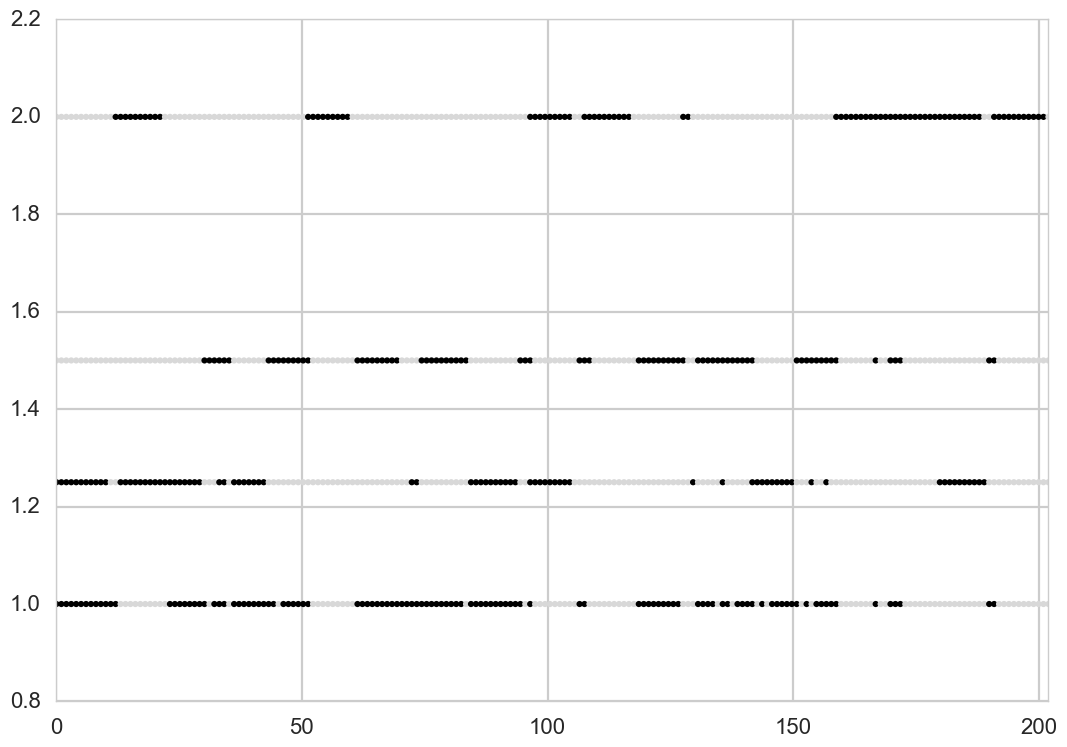

In [345]:
plt.scatter(np.linspace(0,len(z),num=len(z)), 1*np.ones_like(z), c=[c[i] for i in fwd_pass['z']], lw=0)
plt.scatter(np.linspace(0,len(z),num=len(z)), 1.25*np.ones_like(z), c=[c[i] for i in np.argmax(back_messages, axis=1)], lw=0)
plt.scatter(np.linspace(0,len(z),num=len(z)), 1.5*np.ones_like(z), c=[c[i] for i in res], lw=0)

plt.xlim([0,len(z)])

plt.scatter(np.linspace(0,len(z),num=len(z)), 2*np.ones_like(z), c=[c[i] for i in chains], lw=0)
plt.xlim([0,len(z)])